# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository.  You have already used this set but this time I have removed  the first column. The set  `banknote_authentication.csv` can be found in the `data`  directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
data = pd.read_csv('data/banknote_authentication.csv' )

In [3]:
data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. 

Training set confusion matrix:
 [[0.8275154  0.1724846 ]
 [0.19487179 0.80512821]]
Training set ROC AUC score: 0.8921602695730004
Test set confusion matrix:
 [[0.76229508 0.23770492]
 [0.14285714 0.85714286]]
Test set ROC AUC score: 0.8606557377049181


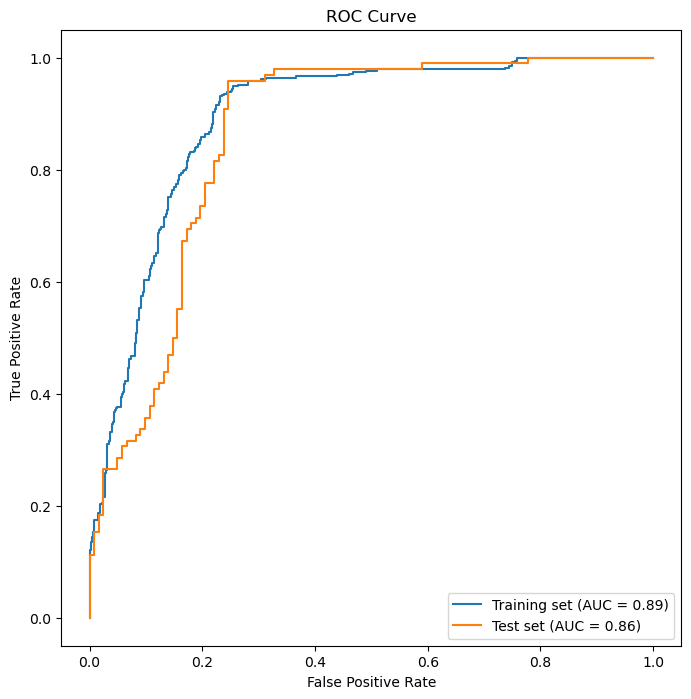

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve

# Load the data
data = pd.read_csv('data/banknote_authentication.csv')

# Separate features and labels
X = data.drop(columns='counterfeit')
y = data['counterfeit']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Initialize and train the QDA model
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)

# Make predictions
y_train_pred = qda.predict(X_train)
y_train_prob = qda.predict_proba(X_train)[:, 1]
y_test_pred = qda.predict(X_test)
y_test_prob = qda.predict_proba(X_test)[:, 1]

# Calculate metrics
train_conf_matrix = confusion_matrix(y_train, y_train_pred, normalize='true')
test_conf_matrix = confusion_matrix(y_test, y_test_pred, normalize='true')
train_roc_auc = roc_auc_score(y_train, y_train_prob)
test_roc_auc = roc_auc_score(y_test, y_test_prob)
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_prob)
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_prob)

# Print metrics
print("Training set confusion matrix:\n", train_conf_matrix)
print("Training set ROC AUC score:", train_roc_auc)
print("Test set confusion matrix:\n", test_conf_matrix)
print("Test set ROC AUC score:", test_roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(train_fpr, train_tpr, label=f'Training set (AUC = {train_roc_auc:.2f})')
plt.plot(test_fpr, test_tpr, label=f'Test set (AUC = {test_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

Test set confusion matrix (GMM):
 [[0.95081967 0.04918033]
 [0.12244898 0.87755102]]
Test set ROC AUC score (GMM): 0.9648711943793911


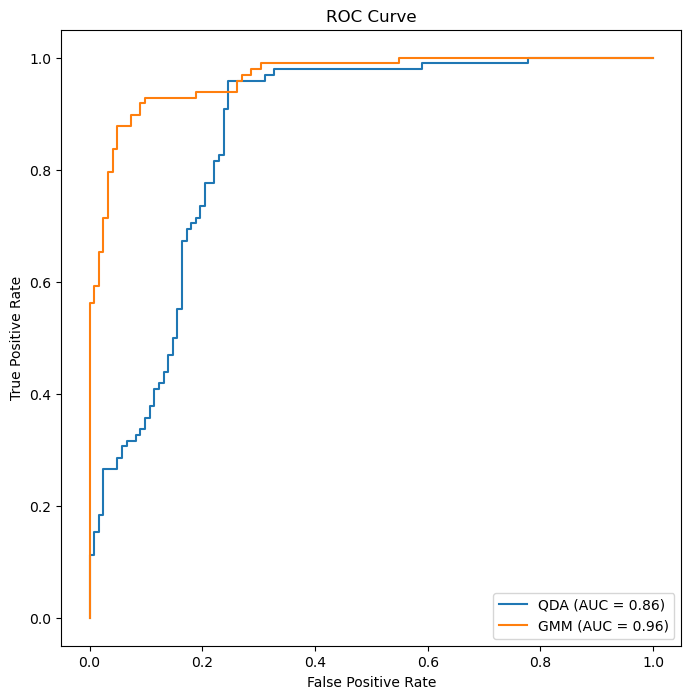

Best GMM Components: (7, 8)
Test set confusion matrix (Best GMM):
 [[0.95081967 0.04918033]
 [0.05102041 0.94897959]]
Test set ROC AUC score (Best GMM): 0.9908832385413182


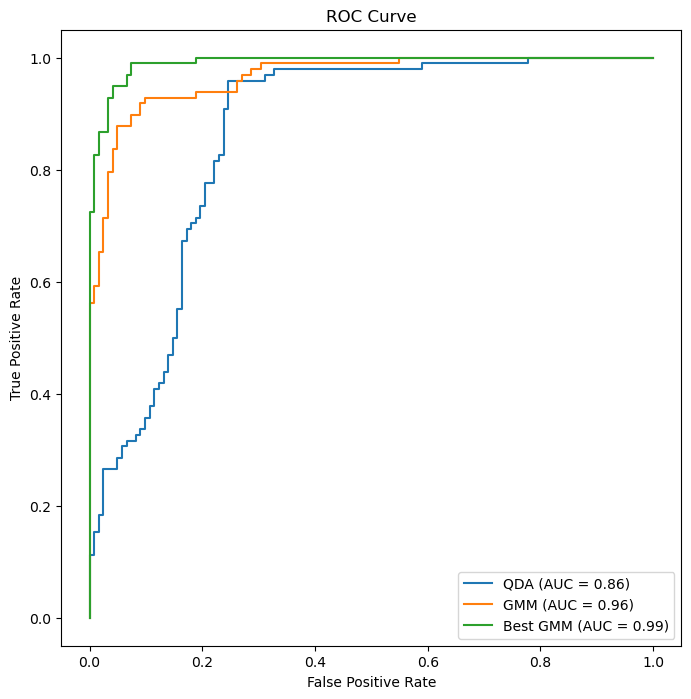

In [6]:
from sklearn.mixture import GaussianMixture

# Initialize Gaussian Mixture Models
gmm_pos = GaussianMixture(n_components=2, random_state=42)
gmm_neg = GaussianMixture(n_components=2, random_state=42)

# Fit the models
gmm_pos.fit(X_train[y_train == 1])
gmm_neg.fit(X_train[y_train == 0])

# Calculate the log likelihood for each class
log_likelihood_pos = gmm_pos.score_samples(X_test)
log_likelihood_neg = gmm_neg.score_samples(X_test)

# Predict based on higher log likelihood
y_test_gmm_pred = (log_likelihood_pos > log_likelihood_neg).astype(int)
y_test_gmm_prob = np.exp(log_likelihood_pos) / (np.exp(log_likelihood_pos) + np.exp(log_likelihood_neg))

# Calculate metrics
test_gmm_conf_matrix = confusion_matrix(y_test, y_test_gmm_pred, normalize='true')
test_gmm_roc_auc = roc_auc_score(y_test, y_test_gmm_prob)
test_gmm_fpr, test_gmm_tpr, _ = roc_curve(y_test, y_test_gmm_prob)

# Print metrics
print("Test set confusion matrix (GMM):\n", test_gmm_conf_matrix)
print("Test set ROC AUC score (GMM):", test_gmm_roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(test_fpr, test_tpr, label=f'QDA (AUC = {test_roc_auc:.2f})')
plt.plot(test_gmm_fpr, test_gmm_tpr, label=f'GMM (AUC = {test_gmm_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Parameters
max_components = 12
k_folds = 5
best_f1_score = 0
best_n_components = (1, 1)  # Initialize with minimal number of components

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for n_pos in range(1, max_components + 1):
    for n_neg in range(1, max_components + 1):
        f1_scores = []
        
        for train_idx, val_idx in skf.split(X, y):
            X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
            
            gmm_pos_cv = GaussianMixture(n_components=n_pos, random_state=42)
            gmm_neg_cv = GaussianMixture(n_components=n_neg, random_state=42)
            
            gmm_pos_cv.fit(X_train_cv[y_train_cv == 1])
            gmm_neg_cv.fit(X_train_cv[y_train_cv == 0])
            
            log_likelihood_pos_cv = gmm_pos_cv.score_samples(X_val_cv)
            log_likelihood_neg_cv = gmm_neg_cv.score_samples(X_val_cv)
            
            y_val_gmm_pred_cv = (log_likelihood_pos_cv > log_likelihood_neg_cv).astype(int)
            f1_scores.append(f1_score(y_val_cv, y_val_gmm_pred_cv))
        
        avg_f1_score = np.mean(f1_scores)
        
        if avg_f1_score > best_f1_score:
            best_f1_score = avg_f1_score
            best_n_components = (n_pos, n_neg)

# Train the best model on the entire training set
best_gmm_pos = GaussianMixture(n_components=best_n_components[0], random_state=42)
best_gmm_neg = GaussianMixture(n_components=best_n_components[1], random_state=42)
best_gmm_pos.fit(X_train[y_train == 1])
best_gmm_neg.fit(X_train[y_train == 0])

log_likelihood_pos_best = best_gmm_pos.score_samples(X_test)
log_likelihood_neg_best = best_gmm_neg.score_samples(X_test)

y_test_gmm_best_pred = (log_likelihood_pos_best > log_likelihood_neg_best).astype(int)
y_test_gmm_best_prob = np.exp(log_likelihood_pos_best) / (np.exp(log_likelihood_pos_best) + np.exp(log_likelihood_neg_best))

# Calculate metrics
test_gmm_best_conf_matrix = confusion_matrix(y_test, y_test_gmm_best_pred, normalize='true')
test_gmm_best_roc_auc = roc_auc_score(y_test, y_test_gmm_best_prob)
test_gmm_best_fpr, test_gmm_best_tpr, _ = roc_curve(y_test, y_test_gmm_best_prob)

# Print metrics
print("Best GMM Components:", best_n_components)
print("Test set confusion matrix (Best GMM):\n", test_gmm_best_conf_matrix)
print("Test set ROC AUC score (Best GMM):", test_gmm_best_roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(test_fpr, test_tpr, label=f'QDA (AUC = {test_roc_auc:.2f})')
plt.plot(test_gmm_fpr, test_gmm_tpr, label=f'GMM (AUC = {test_gmm_roc_auc:.2f})')
plt.plot(test_gmm_best_fpr, test_gmm_best_tpr, label=f'Best GMM (AUC = {test_gmm_best_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. Use the f1-score as the performance metric. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. Assume that maximal number of components in each class is 12. Remember that th enumber of clusters in each class does not have to be equal.  

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

Best GMM Components: (7, 8)
Test set confusion matrix (Best GMM):
 [[0.95081967 0.04918033]
 [0.05102041 0.94897959]]
Test set ROC AUC score (Best GMM): 0.9908832385413182


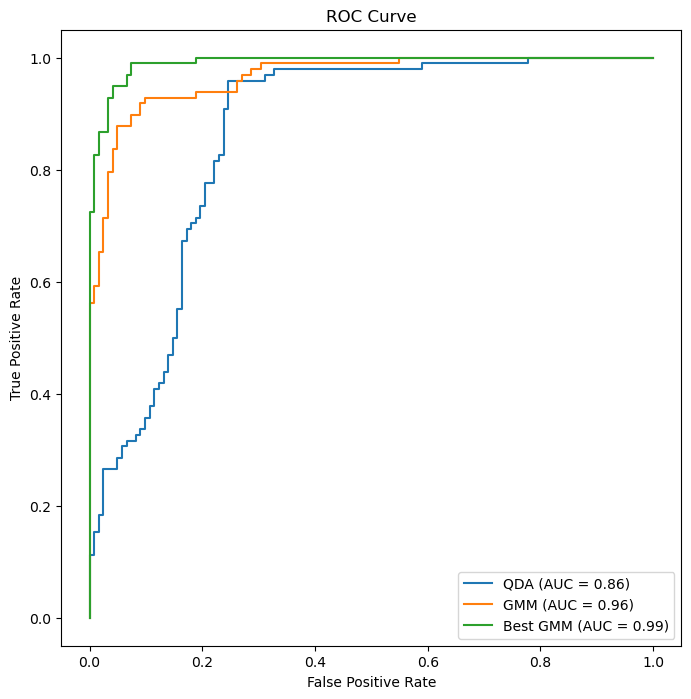

In [7]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

# Parameters
max_components = 12
k_folds = 5
best_f1_score = 0
best_n_components = (1, 1)  # Initialize with minimal number of components

# Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for n_pos in range(1, max_components + 1):
    for n_neg in range(1, max_components + 1):
        f1_scores = []
        
        for train_idx, val_idx in skf.split(X, y):
            X_train_cv, X_val_cv = X.iloc[train_idx], X.iloc[val_idx]
            y_train_cv, y_val_cv = y.iloc[train_idx], y.iloc[val_idx]
            
            gmm_pos_cv = GaussianMixture(n_components=n_pos, random_state=42)
            gmm_neg_cv = GaussianMixture(n_components=n_neg, random_state=42)
            
            gmm_pos_cv.fit(X_train_cv[y_train_cv == 1])
            gmm_neg_cv.fit(X_train_cv[y_train_cv == 0])
            
            log_likelihood_pos_cv = gmm_pos_cv.score_samples(X_val_cv)
            log_likelihood_neg_cv = gmm_neg_cv.score_samples(X_val_cv)
            
            y_val_gmm_pred_cv = (log_likelihood_pos_cv > log_likelihood_neg_cv).astype(int)
            f1_scores.append(f1_score(y_val_cv, y_val_gmm_pred_cv))
        
        avg_f1_score = np.mean(f1_scores)
        
        if avg_f1_score > best_f1_score:
            best_f1_score = avg_f1_score
            best_n_components = (n_pos, n_neg)

# Train the best model on the entire training set
best_gmm_pos = GaussianMixture(n_components=best_n_components[0], random_state=42)
best_gmm_neg = GaussianMixture(n_components=best_n_components[1], random_state=42)
best_gmm_pos.fit(X_train[y_train == 1])
best_gmm_neg.fit(X_train[y_train == 0])

log_likelihood_pos_best = best_gmm_pos.score_samples(X_test)
log_likelihood_neg_best = best_gmm_neg.score_samples(X_test)

y_test_gmm_best_pred = (log_likelihood_pos_best > log_likelihood_neg_best).astype(int)
y_test_gmm_best_prob = np.exp(log_likelihood_pos_best) / (np.exp(log_likelihood_pos_best) + np.exp(log_likelihood_neg_best))

# Calculate metrics
test_gmm_best_conf_matrix = confusion_matrix(y_test, y_test_gmm_best_pred, normalize='true')
test_gmm_best_roc_auc = roc_auc_score(y_test, y_test_gmm_best_prob)
test_gmm_best_fpr, test_gmm_best_tpr, _ = roc_curve(y_test, y_test_gmm_best_prob)

# Print metrics
print("Best GMM Components:", best_n_components)
print("Test set confusion matrix (Best GMM):\n", test_gmm_best_conf_matrix)
print("Test set ROC AUC score (Best GMM):", test_gmm_best_roc_auc)

# Plot ROC curve
plt.figure(figsize=(8, 8))
plt.plot(test_fpr, test_tpr, label=f'QDA (AUC = {test_roc_auc:.2f})')
plt.plot(test_gmm_fpr, test_gmm_tpr, label=f'GMM (AUC = {test_gmm_roc_auc:.2f})')
plt.plot(test_gmm_best_fpr, test_gmm_best_tpr, label=f'Best GMM (AUC = {test_gmm_best_roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


## D.  

Assume that 1% of all the customers in your store try to pay with a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

Optimal threshold (QDA): 0.15151515151515152
Minimum loss (QDA): 3.609090909090909
Optimal threshold (GMM): 0.11111111111111112
Minimum loss (GMM): 3.0870454545454544
Optimal threshold (Best GMM): 0.33333333333333337
Minimum loss (Best GMM): 1.0620454545454545


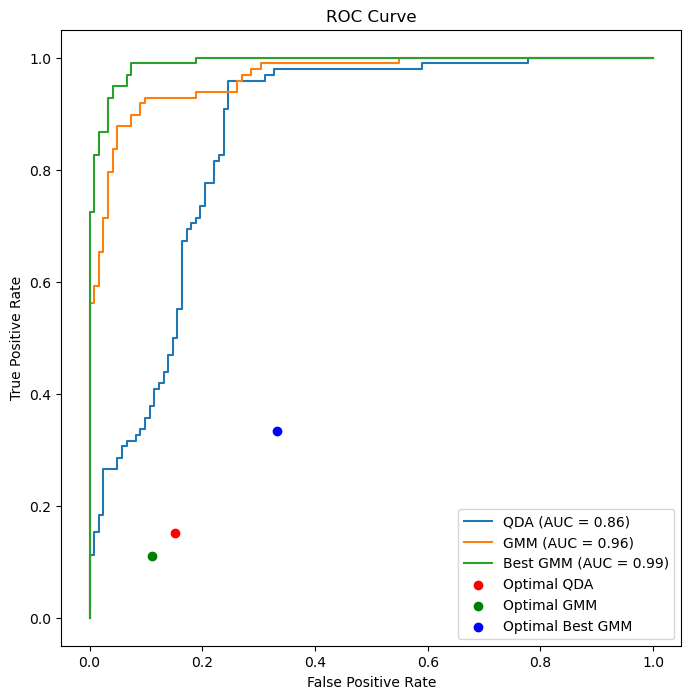

In [8]:
# Cost parameters
cost_false_negative = 100
cost_false_positive = 15 * 0.99

# Function to calculate expected loss
def calculate_expected_loss(y_true, y_prob, threshold, cost_fn, cost_fp):
    y_pred = (y_prob >= threshold).astype(int)
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    total_loss = fp * cost_fp + fn * cost_fn
    return total_loss / len(y_true)

# Find optimal threshold
def find_optimal_threshold(y_true, y_prob, cost_fn, cost_fp):
    thresholds = np.linspace(0, 1, 100)
    losses = [calculate_expected_loss(y_true, y_prob, t, cost_fn, cost_fp) for t in thresholds]
    min_loss = min(losses)
    optimal_threshold = thresholds[losses.index(min_loss)]
    return optimal_threshold, min_loss

# Calculate optimal thresholds and losses for each classifier
optimal_threshold_qda, min_loss_qda = find_optimal_threshold(y_test, y_test_prob, cost_false_negative, cost_false_positive)
optimal_threshold_gmm, min_loss_gmm = find_optimal_threshold(y_test, y_test_gmm_prob, cost_false_negative, cost_false_positive)
optimal_threshold_gmm_best, min_loss_gmm_best = find_optimal_threshold(y_test, y_test_gmm_best_prob, cost_false_negative, cost_false_positive)

# Print optimal thresholds and minimum losses
print("Optimal threshold (QDA):", optimal_threshold_qda)
print("Minimum loss (QDA):", min_loss_qda)
print("Optimal threshold (GMM):", optimal_threshold_gmm)
print("Minimum loss (GMM):", min_loss_gmm)
print("Optimal threshold (Best GMM):", optimal_threshold_gmm_best)
print("Minimum loss (Best GMM):", min_loss_gmm_best)

# Plot ROC curve with optimal points
plt.figure(figsize=(8, 8))
plt.plot(test_fpr, test_tpr, label=f'QDA (AUC = {test_roc_auc:.2f})')
plt.plot(test_gmm_fpr, test_gmm_tpr, label=f'GMM (AUC = {test_gmm_roc_auc:.2f})')
plt.plot(test_gmm_best_fpr, test_gmm_best_tpr, label=f'Best GMM (AUC = {test_gmm_best_roc_auc:.2f})')
plt.scatter(optimal_threshold_qda, optimal_threshold_qda, color='red', label='Optimal QDA')
plt.scatter(optimal_threshold_gmm, optimal_threshold_gmm, color='green', label='Optimal GMM')
plt.scatter(optimal_threshold_gmm_best, optimal_threshold_gmm_best, color='blue', label='Optimal Best GMM')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
